# Processing ZEN data with Aurora

This is an example of how to process ZEN data with Aurora.  For now this is an example of how to process data in the field to get a first-order estimate of what the MT response looks like. 

The order will be:

1. Connect laptop to ZEN and put in SD mode
2. Copy only the files for the desired station
3. Create an MTH5 from the data
4. Processes the a 256 run and a 4096 run
5. Plot results

In [1]:
%matplotlib widget

from pathlib import Path

from mth5 import read_file
from mth5.io.zen import Z3DCollection, zen_tools
from mth5.mth5 import MTH5
from mtpy import MT

2023-05-24 16:39:53,122 [line 141] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log
2023-05-24 16:39:53,291 [line 113] matplotlib.get_mtpy_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mtpy\logs\matplotlib_warn.log


## Important Parameters

Set some important parameters up from so you don't have to search through the notebook.

In [2]:
station = "gz316"
save_path = Path(r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2023").joinpath(station)
mth5_path = save_path.joinpath(f"{station}_with_1s_run.h5")
combine = True

## 2. Create MTH5

Now that the data is downloaded we need to create a MTH5 from which we can visualize and process.  

### Organize data into Runs

The first step is to take an inventory of the data and organize the channels into runs.  This can be done with `Z3DCollection`.  It will group by start time and sample rate, then assign run names with the sample rate and a number indicator.  `sr256_0001` is the first run in the sequence with a sample rate of 256.

In [3]:
zc = Z3DCollection(save_path)
runs = zc.get_runs(sample_rates=[4096, 1024, 256])

zen_station = list(runs.keys())[0]

### Create MTH5

Here we are going to create an MTH5 by iterating over the runs detected with `Z3DCollection`.  We are also going to combine all runs together and downsample to 1 second to use with observatory data as a remote reference. Gaps between schedule actions are filled with mean values and are too small to effect processing, usually 10-20 seconds of missing data.

<div class="alert alert-block alert-warning">
<b>IMPORTANT:</b> Set the survey name as this will be used to place the data under a survey name.  
</div> 

<div class="alert alert-block alert-warning">
<b>IMPORTANT:</b> Be sure to set the path to the induction coil calibration file (usually 'amtant.cal') because the calibration data that comes directly off the Z3D is not correct at the moment, not sure if that is an error in reading or writing.   
</div> 

In [ ]:
m = MTH5()
m.open_mth5(mth5_path)

In [ ]:
%%time
survey_group = m.add_survey("GZ2023")
for station_id in runs.keys():
    station_group = survey_group.stations_group.add_station(station_id)
    station_group.metadata.update(zc.station_metadata_dict[station_id])
    station_group.write_metadata()
    if combine:
        run_list = []
    for run_id, run_df in runs[station_id].items():
        run_group = station_group.add_run(run_id)
        for row in run_df.itertuples():
            ch_ts = read_file(
                row.fn,
                calibration_fn=r"c:\Users\jpeacock\OneDrive - DOI\MTData\antenna_20190411.cal",
            )
            run_group.from_channel_ts(ch_ts)
        run_group.update_run_metadata()
        if combine:
            run_list.append(run_group.to_runts())
    
    if combine:
        # Combine runs and down sample to 1 second.
        combined_run = run_list[0].merge(run_list[1:], new_sample_rate=1)
        combined_run.run_metadata.id = "sr1_0001"
        combined_run_group = station_group.add_run("sr1_0001")
        combined_run_group.from_runts(combined_run)
        combined_run_group.update_run_metadata()

    station_group.update_station_metadata()

survey_group.update_survey_metadata()

In [ ]:
m.close_mth5()

### Combined Run

Here is the combined run data sampled at 1 Hz.

In [ ]:
if combine:
    print(combined_run.__str__())
    combined_run.plot()

## Process With Aurora

In [4]:
# Required imports for the program.
import warnings
from pathlib import Path

from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.transfer_function.kernel_dataset import KernelDataset

from mth5.helpers import close_open_files

warnings.filterwarnings("ignore")

In [5]:
rr_station = "Fresno"
rr_zen_station = "Fresno"
remote_mth5_path = Path(r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2023\usgs_geomag_frn_xy.h5")

In [6]:
close_open_files()

sample_rate = 1
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path, remote_mth5_path])
run_summary = mth5_run_summary.clone()
run_summary.add_duration()
run_summary.df = run_summary.df[run_summary.df.sample_rate == sample_rate].iloc[:]
run_summary.mini_summary

2023-05-24 16:40:02,691 [line 754] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2023\gz316\gz316_with_1s_run.h5
2023-05-24 16:40:02,736 [line 754] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2023\usgs_geomag_frn_xy.h5


,survey,station_id,run_id,start,end
0,GZ2023,316,sr1_0001,2023-05-01 21:04:58+00:00,2023-05-02 16:24:41+00:00
8,USGS-GEOMAG,Fresno,sp1_001,2023-04-26 00:00:00+00:00,2023-05-09 00:00:06+00:00


In [7]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, zen_station, rr_zen_station)
mimimum_run_duration = 100  # seconds
kernel_dataset.drop_runs_shorter_than(mimimum_run_duration)
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end,duration
0,GZ2023,316,sr1_0001,2023-05-01 21:04:58+00:00,2023-05-02 16:24:41+00:00,69583.0
1,USGS-GEOMAG,Fresno,sp1_001,2023-05-01 21:04:58+00:00,2023-05-02 16:24:41+00:00,69583.0


In [27]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(
    kernel_dataset,
    emtf_band_file=r"c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\aurora\aurora\config\emtf_band_setup\bs_six_level.cfg",
)

for decimation in config.decimations:
    decimation.estimator.engine = "RME_RR"
    decimation.window.type = "dpss"
    decimation.window.additional_args = {"alpha":2.5}
    decimation.output_channels = ["ex", "ey"]
    decimation.window.overlap = 64
    decimation.window.num_samples = 128

c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\aurora\aurora\config\emtf_band_setup\bs_six_level.cfg


2023-05-24 17:01:04.099 | INFO     | aurora.pipelines.transfer_function_kernel:memory_warning:225 - Total memory: 31.83 GB
2023-05-24 17:01:04.099 | INFO     | aurora.pipelines.transfer_function_kernel:memory_warning:229 - Total Bytes of Raw Data: 0.001 GB
2023-05-24 17:01:04.111 | INFO     | aurora.pipelines.transfer_function_kernel:memory_warning:232 - Raw Data will use: 0.003 % of memory
2023-05-24 17:01:04,781 [line 664] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2023-05-02T16:24:40+00:00 does not match metadata end 2023-05-02T16:24:41+00:00 updating metatdata value to 2023-05-02T16:24:40+00:00
2023-05-24 17:01:05,054 [line 651] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: start time of dataset 2023-05-01T21:04:58+00:00 does not match metadata start 2023-04-26T00:00:00+00:00 updating metatdata value to 2023-05-01T21:04:58+00:00
2023-05-24 17:01:05,062 [line 664] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dat

2023-05-24T17:01:05 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 17.220424s
2023-05-24T17:01:05 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 13.548957s
2023-05-24T17:01:05 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 10.750989s
2023-05-24T17:01:06 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 8.327681s
2023-05-24T17:01:06 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 6.311855s
2023-05-24T17:01:06 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 4.467911s


2023-05-24 17:01:07.264 | INFO     | aurora.pipelines.process_mth5:update_dataset_df:238 - DECIMATION LEVEL 1
2023-05-24 17:01:07.304 | DEBUG    | aurora.pipelines.process_mth5:update_dataset_df:251 - DATASET DF UPDATED
2023-05-24 17:01:07,615 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-05-24 17:01:07,659 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-05-24 17:01:07.748 | WARNING  | aurora.pipelines.time_series_helpers:calibrate_stft_obj:275 - UNEXPECTED CHANNEL WITH NO FILTERS
2023-05-24 17:01:07.768 | WARNING  | aurora.pipelines.time_series_helpers:calibrate_stft_obj:275 - UNEXPECTED CHANNEL WITH NO FILTERS


2023-05-24T17:01:07 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 94.668833s
2023-05-24T17:01:07 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 68.881694s
2023-05-24T17:01:07 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 43.003958s
2023-05-24T17:01:08 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 33.310722s
2023-05-24T17:01:08 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 25.247420s


2023-05-24 17:01:08.291 | INFO     | aurora.pipelines.process_mth5:update_dataset_df:238 - DECIMATION LEVEL 2
2023-05-24 17:01:08.317 | DEBUG    | aurora.pipelines.process_mth5:update_dataset_df:251 - DATASET DF UPDATED
2023-05-24 17:01:08,649 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-05-24 17:01:08,693 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-05-24 17:01:08.782 | WARNING  | aurora.pipelines.time_series_helpers:calibrate_stft_obj:275 - UNEXPECTED CHANNEL WITH NO FILTERS
2023-05-24 17:01:08.801 | WARNING  | aurora.pipelines.time_series_helpers:calibrate_stft_obj:275 - UNEXPECTED CHANNEL WITH NO FILTERS


2023-05-24T17:01:08 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 378.675334s
2023-05-24T17:01:08 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 275.526776s
2023-05-24T17:01:08 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 216.783308s
2023-05-24T17:01:08 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 172.015831s
2023-05-24T17:01:09 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 133.242890s


2023-05-24 17:01:09.157 | INFO     | aurora.pipelines.process_mth5:update_dataset_df:238 - DECIMATION LEVEL 3
2023-05-24 17:01:09.173 | DEBUG    | aurora.pipelines.process_mth5:update_dataset_df:251 - DATASET DF UPDATED
2023-05-24 17:01:09,453 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-05-24 17:01:09,497 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-05-24 17:01:09.584 | WARNING  | aurora.pipelines.time_series_helpers:calibrate_stft_obj:275 - UNEXPECTED CHANNEL WITH NO FILTERS
2023-05-24 17:01:09.604 | WARNING  | aurora.pipelines.time_series_helpers:calibrate_stft_obj:275 - UNEXPECTED CHANNEL WITH NO FILTERS


2023-05-24T17:01:09 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 1514.701336s
2023-05-24T17:01:09 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 1042.488956s
2023-05-24T17:01:09 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 723.371271s
2023-05-24T17:01:09 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 532.971560s


2023-05-24 17:01:09.877 | INFO     | aurora.pipelines.process_mth5:update_dataset_df:238 - DECIMATION LEVEL 4
2023-05-24 17:01:09.891 | DEBUG    | aurora.pipelines.process_mth5:update_dataset_df:251 - DATASET DF UPDATED
2023-05-24 17:01:10,166 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-05-24 17:01:10,214 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-05-24 17:01:10.303 | WARNING  | aurora.pipelines.time_series_helpers:calibrate_stft_obj:275 - UNEXPECTED CHANNEL WITH NO FILTERS
2023-05-24 17:01:10.324 | WARNING  | aurora.pipelines.time_series_helpers:calibrate_stft_obj:275 - UNEXPECTED CHANNEL WITH NO FILTERS


2023-05-24T17:01:10 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 6058.805343s
2023-05-24T17:01:10 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 4169.955823s
2023-05-24T17:01:10 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 2893.485085s
2023-05-24T17:01:10 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 2131.886239s


2023-05-24 17:01:13,057 [line 754] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2023\gz316\gz316_with_1s_run.h5
2023-05-24 17:01:13,057 [line 754] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2023\usgs_geomag_frn_xy.h5
2023-05-24 17:01:13,071 [line 337] mt_metadata.base.metadata.define_measurement.write_measurement - WARNING: No XMEAS information.
2023-05-24 17:01:13,085 [line 337] mt_metadata.base.metadata.define_measurement.write_measurement - WARNING: No XMEAS information.


=== FINISHED ===


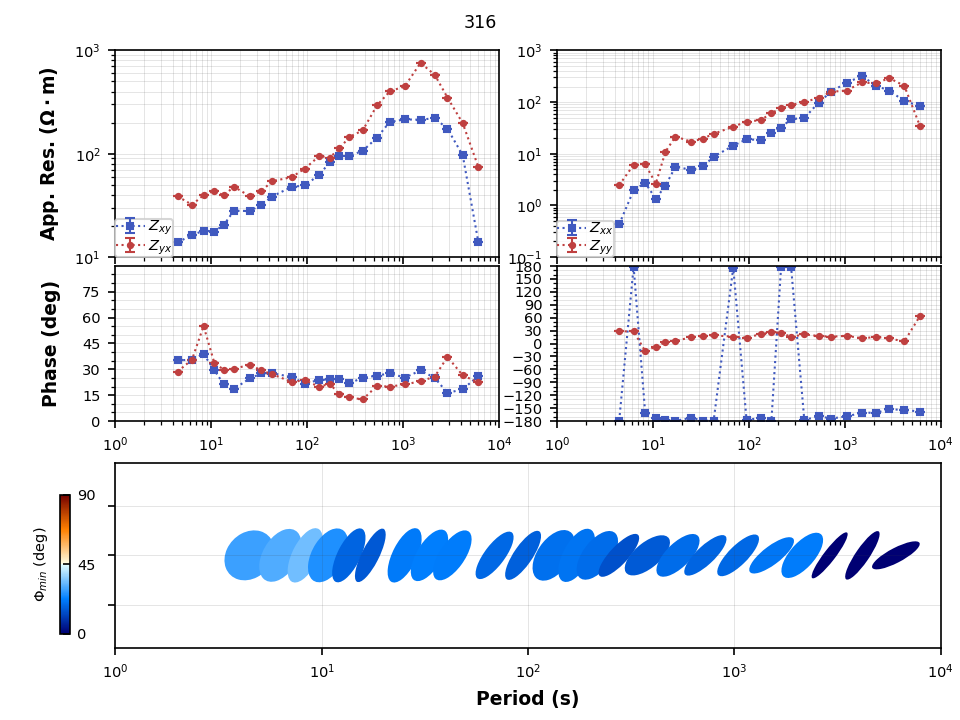

2023-05-24 17:01:14,951 [line 134] mtpy.imaging.plot_mt_response.PlotMTResponse.save_plot - INFO: Saved figure to: c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2023\gz316\gz316_1_w64.png


Wall time: 10.9 s


In [28]:
%%time
tf_cls = process_mth5(
    config,
    kernel_dataset,
    units="MT",
    show_plot=False,
    z_file_path=None,
)
print("=== FINISHED ===")

edi = tf_cls.write(mth5_path.parent.joinpath(f"{station}_{sample_rate}_w64.edi"))

# plot with MTpy
mt_obj = MT()
mt_obj.read(edi.fn)
p1 = mt_obj.plot_mt_response(fig_num=1, plot_num=2)
p1.save_plot(save_path.joinpath(f"{edi.fn.stem}.png"), fig_dpi=300, close_plot=False)

In [22]:
config

{
    "processing": {
        "band_setup_file": "c:\\Users\\jpeacock\\OneDrive - DOI\\Documents\\GitHub\\aurora\\aurora\\config\\emtf_band_setup\\bs_six_level.cfg",
        "band_specification_style": "EMTF",
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "hx",
        "channel_nomenclature.hy": "hy",
        "channel_nomenclature.hz": "hz",
        "decimations": [
            {
                "decimation_level": {
                    "anti_alias_filter": "default",
                    "bands": [
                        {
                            "band": {
                                "decimation_level": 0,
                                "frequency_max": 0.26171875,
                                "frequency_min": 0.19140625,
                                "index_max": 33,
                                "index_min": 25
                            }
                        },
                        {
    